In [293]:
#DADOS IRI 2016 
#LOCAL: kansas-eua(2)
#COORDINATE: LAT 2° 23' 51'' LON 44° 24' 16'' (2)
#DATA 10/10/2002
#12:00 HORA GLOBAL/ UNIVERSAL
#HEIGHT: 90-1000 Km - step 1


In [347]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from sys import argv
import math
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [349]:


# Carregando os dados originais fornecidos anteriormente
dados = np.loadtxt("0108_00.txt", unpack=True)

# Atribuindo as variáveis (conforme nomes originais)
km00, Ne00, NeNmF200, Tn00, Tk00, TeK00, pO00, pN00, pH00, pHe00, pO2O0, pNO00, Clust00, TEC00, t00, N200, O200, O00, NO00 = dados

# Conversão de cm⁻³ para m⁻³
cm3_to_m3 = 1e6

# Lista dos íons e suas variáveis correspondentes
frac_ions = {
    'O⁺': pO00,
    'N⁺': pN00,
    'H⁺': pH00,
    'He⁺': pHe00,
    'O2⁺': pO2O0,
    'NO⁺': pNO00,
    'Clust': Clust00,
}

# Cálculo das densidades absolutas em m⁻³
densidades_m3 = {
    ion: (frac / 10) * NeNmF200 * cm3_to_m3
    for ion, frac in frac_ions.items()
}

#print(pHe00)
#print(densidades_m3['He⁺'])

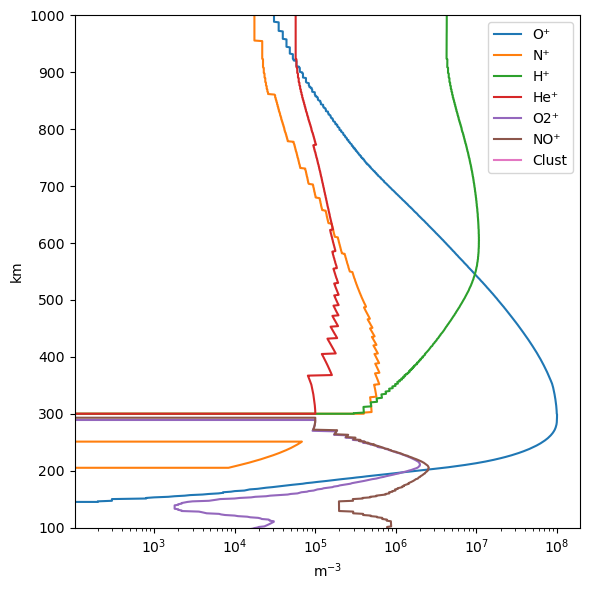

O⁺: 1.00e+08 el/m³ na altitude 290.0 km
N⁺: 0.00e+00 el/m³ na altitude 290.0 km
H⁺: 0.00e+00 el/m³ na altitude 290.0 km
He⁺: 0.00e+00 el/m³ na altitude 290.0 km
O2⁺: 0.00e+00 el/m³ na altitude 290.0 km
NO⁺: 1.00e+05 el/m³ na altitude 290.0 km
Clust: -1.00e+05 el/m³ na altitude 290.0 km


In [366]:


# Plot
plt.figure(figsize=(6, 6))
for ion, dens in densidades_m3.items():
    plt.plot(dens, km00, label=ion)

plt.xlabel(r'$\mathrm{m}^{-3}$')
plt.ylabel('km')
#plt.title('Densidade absoluta dos íons (usando Ne00)')
plt.legend()
plt.ylim(100, 1000)
plt.xscale('log')
plt.tight_layout()
plt.show()

# Exemplo: imprime densidade do primeiro ponto de altitude
for ion, dens in densidades_m3.items():
    print(f"{ion}: {dens[200]:.2e} el/m³ na altitude {km00[200]:.1f} km")





In [352]:
# Suavização específica para He⁺ com interpolação 
def suavizar_com_media_e_interpolacao(x, y, window=200):
    y = np.array(y)
    y_suavizado = y.copy()

    # 1. Preencher valores NaN ou zero com média local onde possível
    for i in range(len(y)):
        if not np.isfinite(y[i]) or y[i] == 0:
            vizinhos = y[max(0, i - window):min(len(y), i + window + 1)]
            vizinhos_validos = vizinhos[(np.isfinite(vizinhos)) & (vizinhos > 0)]
            if len(vizinhos_validos) > 0:
                y_suavizado[i] = np.mean(vizinhos_validos)

    # 2. Interpolação linear para garantir continuidade
    mascara = np.isfinite(y_suavizado) & (y_suavizado > 0)
    if np.sum(mascara) > 4:
        interpolador = interp1d(x[mascara], y_suavizado[mascara], kind='linear', fill_value='extrapolate')
        y_suavizado = interpolador(x)

    # 3. Filtro de Savitzky-Golay para suavizar a curva  mantendo tendência geral (com window_length=105 ).
    try:
        y_suavizado = savgol_filter(y_suavizado, window_length=105, polyorder=2)
    except:
        pass

    return y_suavizado



In [353]:
#smoothing with gap filling
#This approach is modular and simpler.

from scipy.interpolate import interp1d


#Only fills in NaN values via linear interpolation.
#Does not treat zeros, nor does it do local averaging.

def preencher_nans(x, y):
    """Interpolação linear simples para preencher NaNs"""
    y_interp = y.copy()
    mask = np.isfinite(y_interp)
    if np.sum(mask) > 3:
        interp_func = interp1d(x[mask], y_interp[mask], kind='linear', fill_value="extrapolate")
        y_interp = interp_func(x)
    return y_interp


#Cleaner data, with few NaNs.
#When you want to control the level of smoothing (light or strong).
#Cases where zeros are valid values (and not noise).
def suavizar_dados(x, y, window=21, poly=2):
    y_clean = preencher_nans(x, y)
    try:
        y_smooth = savgol_filter(y_clean, window_length=window, polyorder=poly)
        return y_smooth
    except:
        return y_clean

#changing only the window value for heavy smoothing
def suavizar_dados_var(x, y, window=121, poly=2):
    y_clean_var = preencher_nans(x, y)
    try:
        y_smooth_var = savgol_filter(y_clean_var, window_length=window, polyorder=poly)
        return y_smooth_var
    except:
        return y_clean_var


#changing only the window value for more heavy smoothing
def suavizar_dados_diff(x, y, window=331, poly=2):
    y_clean_diff = preencher_nans(x, y)
    try:
        y_smooth_diff = savgol_filter(y_clean_diff, window_length=window, polyorder=poly)
        return y_smooth_diff
    except:
        return y_clean_diff



In [354]:
#Exemplos de como definir o tipo de tratamento quer 

dens_he_suave = suavizar_com_media_e_interpolacao(km00, densidades_m3['He⁺'])
dens_h_suave = suavizar_com_media_e_interpolacao(km00, densidades_m3['H⁺'])
dens_NO_suave = suavizar_com_media_e_interpolacao(km00, densidades_m3['NO⁺'])
dens_O2_suave = suavizar_com_media_e_interpolacao(km00, densidades_m3['O2⁺'])







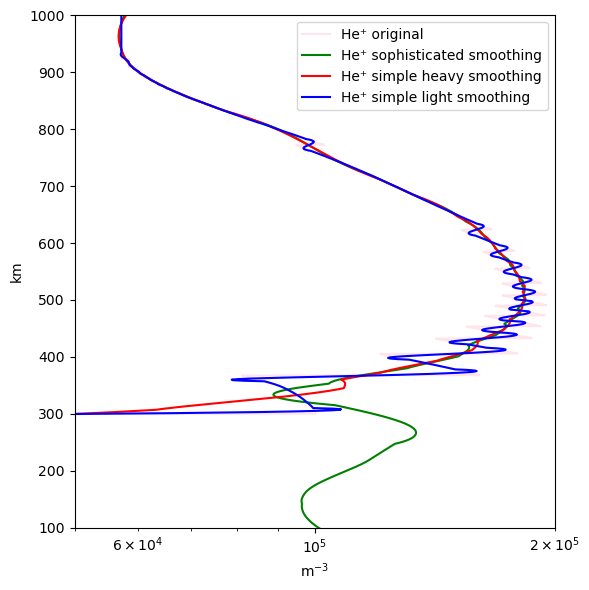

In [355]:

# Plotando a comparação
plt.figure(figsize=(6, 6))
plt.plot(densidades_m3['He⁺'], km00, label='He⁺ original', alpha=0.4, color='pink')
plt.plot(dens_he_suave, km00, label='He⁺ sophisticated smoothing', color='green')
plt.plot(suavizar_dados_var(km00, densidades_m3['He⁺']), km00, label='He⁺ simple heavy smoothing', color='red')
plt.plot(suavizar_dados(km00, densidades_m3['He⁺']), km00, label='He⁺ simple light smoothing', color='blue')

plt.xlabel(r'$\mathrm{m}^{-3}$')
plt.ylabel('km')
#plt.title('Densidade absoluta do íon He⁺ ')
plt.xscale('log')
plt.ylim(100, 1000)

plt.xlim(0.5e5, 2e5)
plt.legend()
plt.tight_layout()
plt.show()


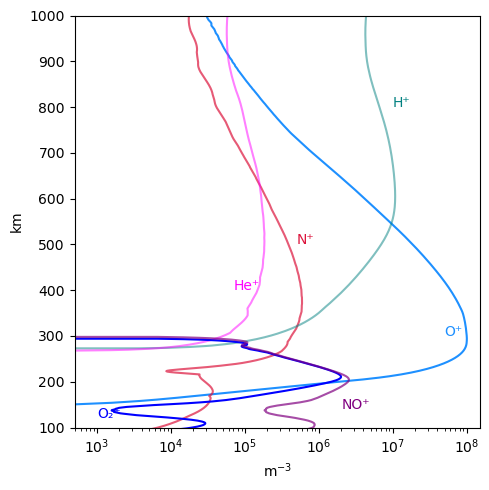

In [359]:
#Here we used different smoothing modes to get closer to the real curve, since depending on the data the smoothing was more or less appropriate.




plt.figure(figsize=(6, 5))
plt.plot(suavizar_dados(km00, densidades_m3['O⁺']), km00, label='O⁺', color='dodgerblue') #um pouco diferente (pico) em relação ao iri
plt.text(0.5e8, 300, 'O⁺', color='dodgerblue') 
plt.plot(dens_N_suave, km00, label='N⁺ suavizado ',alpha=0.7, color='crimson') #mais proximo do iri
plt.text(0.5e6, 500, 'N⁺', color='crimson')
plt.plot(suavizar_dados_var(km00, densidades_m3['H⁺']), km00, label='H⁺',alpha=0.5, color='teal') # proximo de iri, os valore começam em 600 no iri, aqui é em 300
plt.text(1e7, 800, 'H⁺', color='teal') #ok
plt.plot(suavizar_dados_var(km00, densidades_m3['He⁺']), km00, label='He⁺',alpha=0.5, color='fuchsia') # proximo de iri, os valore começam em 600 no iri, aqui é em 280
plt.text(0.7e5, 400, 'He⁺', color='fuchsia') #ok
plt.plot(suavizar_dados(km00, densidades_m3['O2⁺']), km00, label='O2⁺', color='blue') #mais proximo de iri
plt.text(1e3, 120, 'O₂⁺', color='blue')
plt.plot(suavizar_dados(km00, densidades_m3['NO⁺']), km00, label='NO⁺', alpha=0.7, color='purple')
plt.text(2e6, 140, 'NO⁺', color='purple')


plt.xlabel(r'$\mathrm{m}^{-3}$')
plt.ylabel('km')
#plt.title('Densidade absoluta dos íons (suavizado - Ne00)')
plt.ylim(100, 1000)
plt.xscale('log')
plt.xlim(0.5e3, 1.5e8)  # Define intervalo no eixo x
plt.tight_layout()
plt.savefig('densidade_ions.png', dpi=300)  # dpi ajusta a resolução
plt.show()


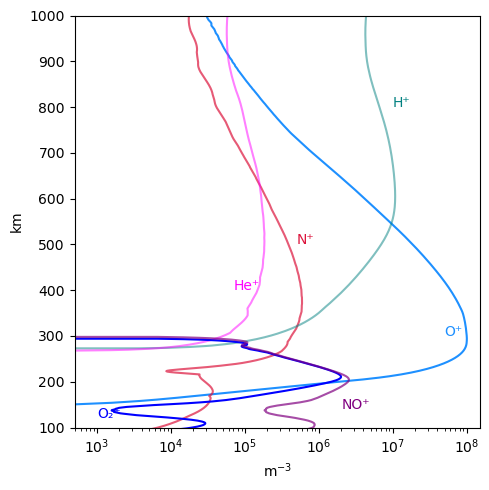

In [289]:
plt.figure(figsize=(5, 5))


plt.plot(suavizar_dados(km00, densidades_m3['O⁺']), km00, label='O⁺', color='dodgerblue') #um pouco diferente (pico) em relação ao iri
plt.text(0.5e8, 300, 'O⁺', color='dodgerblue') 
plt.plot(dens_N_suave, km00, label='N⁺ suavizado ',alpha=0.7, color='crimson') #mais proximo do iri
plt.text(0.5e6, 500, 'N⁺', color='crimson')
plt.plot(suavizar_dados_var(km00, densidades_m3['H⁺']), km00, label='H⁺',alpha=0.5, color='teal') # proximo de iri, os valore começam em 600 no iri, aqui é em 300
plt.text(1e7, 800, 'H⁺', color='teal') #ok
plt.plot(suavizar_dados_var(km00, densidades_m3['He⁺']), km00, label='He⁺',alpha=0.5, color='fuchsia') # proximo de iri, os valore começam em 600 no iri, aqui é em 280
plt.text(0.7e5, 400, 'He⁺', color='fuchsia') #ok
plt.plot(suavizar_dados(km00, densidades_m3['O2⁺']), km00, label='O2⁺', color='blue') #mais proximo de iri
plt.text(1e3, 120, 'O₂⁺', color='blue')
plt.plot(suavizar_dados(km00, densidades_m3['NO⁺']), km00, label='NO⁺', alpha=0.7, color='purple')
plt.text(2e6, 140, 'NO⁺', color='purple')


plt.xlabel(r'$\mathrm{m}^{-3}$')
plt.ylabel('km')
#plt.title('Densidade absoluta dos íons (suavizado - Ne00)')
plt.ylim(100, 1000)
plt.xscale('log')
plt.xlim(0.5e3, 1.5e8)  # Define intervalo no eixo x
plt.tight_layout()
plt.savefig('densidade_ions.png', dpi=300)  # dpi ajusta a resolução
plt.show()
